In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from skimage.util import random_noise

In [2]:
# Flattening the images together
path = 'PATH_TO_DATA_FOLDER'
img_single = [] # storing all the flattened images.
train_y = [] # storing the original images without any noise as ground truths.
test_y = []

for i,file in enumerate(sorted(os.listdir(path))):
    try:
        image = cv2.imread(os.path.join(path, file), 0) # grayscale
        img_resized = cv2.resize(image, (64,64))
        image_flat = img_resized.flatten()
        img_single.append(image_flat)
        if(i<=30): #10% of 300 images in test data
            test_y.append(img_resized)
        else:
            train_y.append(img_resized)
    except Exception as e:
        continue

img_single_arr = np.asarray(img_single)
print(img_single_arr.shape)

(322, 4096)


In [3]:
train_y_arr = np.asarray(train_y)/255.0 # All the original and noised images should have values = [0,1]
test_y_arr = np.asarray(test_y)/255.0
train_y_arr = train_y_arr[:,:,:,np.newaxis].astype('float32') # making (batch, width, height, channel) form
test_y_arr = test_y_arr[:,:,:,np.newaxis].astype('float32')
print(train_y_arr.shape)
print(test_y_arr.shape)

(292, 64, 64, 1)
(30, 64, 64, 1)


In [4]:
# Adding salt and pepper noise with 10% amount
noisy_img_scaled = random_noise(img_single_arr, mode='s&p',  amount=0.1)
print(noisy_img_scaled.shape)

(322, 4096)


In [6]:
# Reshaping back into individual images
train_x = [] #storining the noised images for training the AE
test_x = []
for x in range(0, noisy_img_scaled.shape[0]):
    img_arr = noisy_img_scaled[x, :].reshape(64,64)
    if(x<30): #10% of 300 images for test data
        test_x.append(img_arr)
    else:
        train_x.append(img_arr)

train_x_arr = np.asarray(train_x)
train_x_arr = train_x_arr[:,:,:,np.newaxis] # making (batch, width, height, channel) form
print(train_x_arr.shape)
test_x_arr = np.asarray(test_x)
test_x_arr = test_x_arr[:,:,:,np.newaxis]
print(test_x_arr.shape)

(292, 64, 64, 1)
(30, 64, 64, 1)


### Defining the Model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from skimage.metrics import structural_similarity as ssim

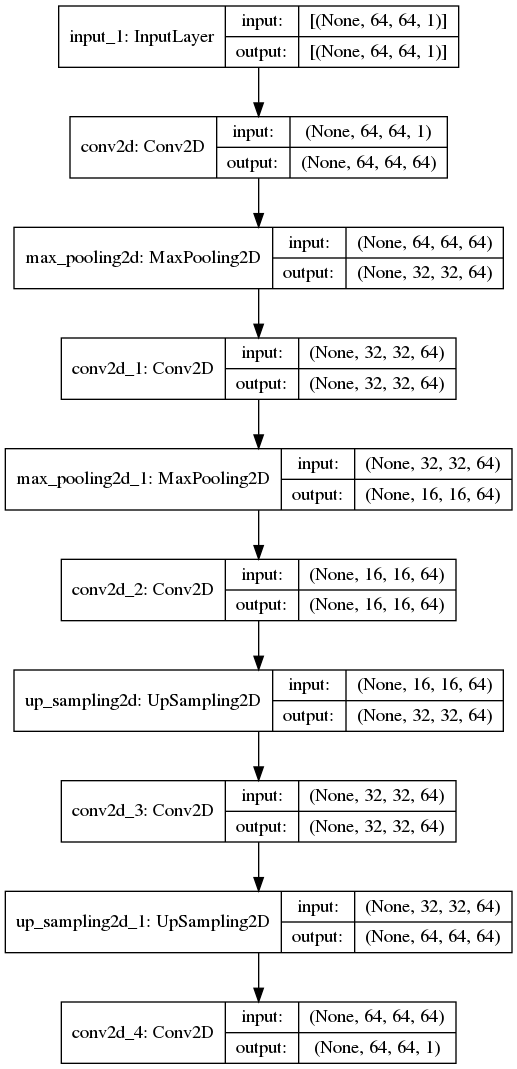

In [8]:
# model architecture
input = layers.Input(shape=(64,64,1))
down = layers.Conv2D(64, (3,3), activation='relu', padding='same')(input)
down = layers.MaxPooling2D(pool_size=(2,2))(down)
down = layers.Conv2D(64, (3,3), activation='relu', padding='same')(down)
down = layers.MaxPooling2D(pool_size=(2,2))(down)
down = layers.Conv2D(64, (3,3), activation='relu', padding='same')(down)
up = layers.UpSampling2D(2)(down)
up = layers.Conv2D(64, (3,3), activation='relu', padding='same')(up)
up = layers.UpSampling2D(2)(up)
output = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(up)

model = Model(inputs=input, outputs=output)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 64)        0     

In [10]:
# Structural Similarity Index as a loss function

def loss_fn(y_true, y_pred):
    return(1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)))
    #max_val=1 because we have image values=[0,1]
    # Returning=(1-SSIM) as we want to minimize the less similar images

In [11]:
# Time based learning rate scheduling

epoch=100
# learning_rate=0.01
# decay_rate=learning_rate/epoch
# momentum=0.8
# sgd=SGD(lr=learning_rate,momentum=momentum,decay=decay_rate)

In [12]:
# Early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [13]:
# compiling the model 
model.compile(loss=loss_fn, optimizer='rmsprop', run_eagerly=True)

In [14]:
model_history=model.fit(train_x_arr, train_y_arr, batch_size = 10, epochs = epoch,
                        validation_split = 0.1, shuffle = True, callbacks = [callback])

Epoch 1/100
27/27 [==============================] - 18s 661ms/step - loss: 0.6113 - val_loss: 0.3805
Epoch 2/100
27/27 [==============================] - 18s 658ms/step - loss: 0.2751 - val_loss: 0.2282
Epoch 3/100
27/27 [==============================] - 17s 639ms/step - loss: 0.2362 - val_loss: 0.1669
Epoch 4/100
27/27 [==============================] - 17s 642ms/step - loss: 0.2156 - val_loss: 0.1731
Epoch 5/100
27/27 [==============================] - 17s 648ms/step - loss: 0.2015 - val_loss: 0.1621
Epoch 6/100
27/27 [==============================] - 17s 638ms/step - loss: 0.1830 - val_loss: 0.1582
Epoch 7/100
27/27 [==============================] - 17s 638ms/step - loss: 0.1690 - val_loss: 0.1770
Epoch 8/100
27/27 [==============================] - 17s 640ms/step - loss: 0.1615 - val_loss: 0.1510
Epoch 9/100
27/27 [==============================] - 17s 641ms/step - loss: 0.1570 - val_loss: 0.2288
Epoch 10/100
27/27 [==============================] - 17s 640ms/step - loss: 0.161

#### Plotting results and predicted images

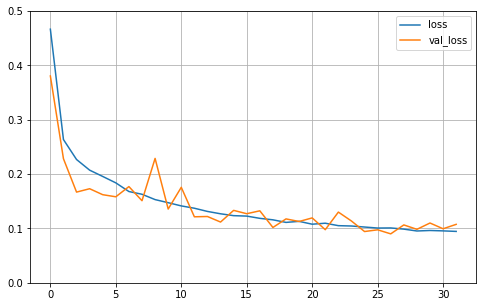

In [15]:
# plotting the varoius metrics
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.5)
plt.show()

In [16]:
# Testing the model
model.evaluate(test_x_arr, test_y_arr)

1/1 [==============================] - 0s 418ms/step - loss: 0.1069


0.10688400268554688

**Noised and Denoised results:**

(64, 64, 1)


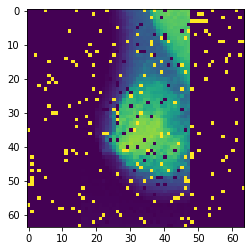

In [17]:
test_img = test_x_arr[0]
print(test_img.shape)
plt.imshow(test_img)

(1, 64, 64, 1)


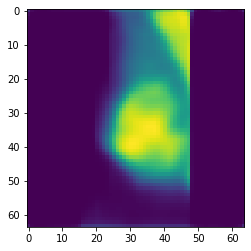

In [18]:
test_img_axis = test_img[np.newaxis,:,:,:]
# print(test_img_axis.shape)
test_img_pred = model.predict(test_img_axis)

print(test_img_pred.shape)
plt.imshow(np.squeeze(test_img_pred))

### Conclusion
This code is an implementation of the paper - ***Medical image denoising using convolutional
denoising autoencoders*** (https://arxiv.org/pdf/1608.04667.pdf).

The model performs satisfactorily well given the small amount of data (less than 300 for training) and a very simple model architecture. This proves the point of the paper that we can use AutoEncoders for denoising even with very less sample of data.
The data used for this experiment was - **MIAS MiniMammographic Database**, (REFERENCE: *J Suckling et al (1994) "The Mammographic Image Analysis Society Digital Mammogram Database" Exerpta Medica. International Congress Series 1069 pp375-378.*), containing 322 images in total. I used 30 images for test and out of 292 remaining, I made a validation split of 10% while training.

The model evaluation gives a loss of 0.106, ie Loss = 1-SSIM => SSIM = 1-0.106 = **0.894** which is quite well.
From further here, we can improve this work to try using MSE loss, different noises, deeper architectures with skip connections, more data, etc.